In [3]:
import os
import glob
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt # For Confusion Matrix visualization
import seaborn as sns
import gc  # Garbage collection
from sklearn.feature_selection import SelectKBest, f_classif #For image size selection
from pathlib import Path

In [ ]:
# Combine training and validation data (assuming you have separate validation data)
X = np.concatenate((np.load(Path("../../../data/ML/X_train_ml.npy")), np.load(Path("../../../data/Ml/X_val_ml.npy"))), axis=0)
y = np.concatenate((np.load(Path("../../../data/ML/y_train_ml.npy")), np.load(Path("../../../data/Ml/y_val_ml.npy"))), axis=0)

X_test = np.load(Path("../../../data/ML/X_test_ml.npy"))
y_test = np.load(Path("../../../data/ML/y_test_ml.npy"))

# Clear unnecessary variables to free up memory
# del X_train, X_val, y_train, y_val
gc.collect()

#Feature Selection
num_features_to_select = 100  # Adjust this value
selector = SelectKBest(score_func=f_classif, k=num_features_to_select)
X_new = selector.fit_transform(X, y)
X_test = selector.transform(X_test)

print(f"Selected {num_features_to_select} best features")

# Clear unnessary variables to save the memory
gc.collect()

Selected 100 best features


0

#### Model function defination

In [7]:
def train_and_evaluate_svm(X, y, X_test, y_test, joblib_file, k_folds=5):
    """Trains and evaluates an SVM model with k-fold cross-validation, logging metrics and artifacts to MLflow."""

    # Define the parameter grid
    param_grid = {'C': [0.1, 1, 10],
                  'gamma': [0.001, 0.1, 'scale'],
                  'kernel': ['rbf', 'linear', 'poly']}

    #Create the SVM model
    model = SVC(random_state=42, class_weight='balanced')

    #Perform Randomized Search with cross-validation
    random_search = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=10, cv=k_folds, scoring='f1_weighted', verbose=2, n_jobs=-1, random_state=42) #Reduce n_iter value if running out of memory again
    random_search.fit(X, y)

    # Get the best model from Grid Search
    best_model = random_search.best_estimator_

    # Print the best parameters
    print("Best Parameters:", random_search.best_params_)

    # Train the model on the entire training + validation dataset
    best_model.fit(X, y)

    # Evaluate the model on the test set
    y_test_pred = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred)

    # Calculate additional metrics
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    confusion = confusion_matrix(y_test, y_test_pred)

    # Log confusion matrix as an image
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig("confusion_matrix.png") # Save confusion matrix

    # Save the model
    joblib.dump(best_model, joblib_file)
    print(f"Saved model to: {joblib_file}")

    # Print results
    print(f"Test Accuracy: {test_accuracy}")
    print(f"Test Precision: {test_precision}")
    print(f"Test Recall: {test_recall}")
    print(f"Test F1 Score: {test_f1}")
    print(f"Classification Report:\n{test_report}")

    return best_model

### Train and evaluate the SVM model

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Saved model to: svm_model.joblib
Test Accuracy: 0.5770731707317073
Test Precision: 0.5978952663583306
Test Recall: 0.5770731707317073
Test F1 Score: 0.564697059733611
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.54      0.63      4422
           1       0.42      0.32      0.36      1776
           2       0.53      0.87      0.66      3138
           3       0.39      0.27      0.32       914

    accuracy                           0.58     10250
   macro avg       0.52      0.50      0.49     10250
weighted avg       0.60      0.58      0.56     10250



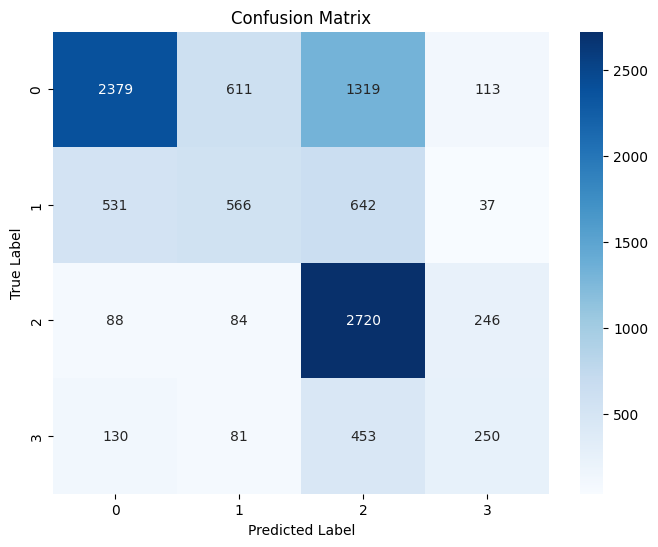

In [8]:
joblib_file = "svm_model.joblib"
trained_model = train_and_evaluate_svm(X_new, y, X_test, y_test, joblib_file, k_folds=5)